# Using `spelunker` to study JWST Time Series Observations (TSOs)

---
**Authors:** Néstor Espinoza (nespinoza@stsci.edu), Derod Deal (dealderod@ufl.edu)  | **Last update:** Apr 16, 2024

**Program version:** ver. 1.1.9

JWST Time Series Observations (TSOs) are multi-integration exposures typically targeted at exploring time-varying phenomena: from exoplanetary transits to accreting material in distant objects. Guidestar data such as the one `spelunker` can query can become very helpful at exploring this data; this tutorial provides an introduction on how to use the `spelunker` products to analyze it.

# 1. The case of HAT-P-14 b NIRISS/SOSS observations

The first dataset we will be analyzing below comes from an exoplanetary transit obtained by [Program ID 1541](https://www.stsci.edu/jwst/science-execution/program-information?id=1541) (PI: Espinoza). This dataset was already introduced in [Albert et al. (2023)](https://arxiv.org/abs/2306.04572), and consisted of a transit observation of the exoplanet HAT-P-14 b, which was used to test the sensitivity and stability of the NIRISS/SOSS instrument during commissioning.  

To start the analysis, let's load some libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import spelunker

In [2]:
spelunker.__version__

'1.1.9'

### 1.1 Exploring the transit event of HAT-P-14 b

Let's first load and plot the NIRISS/SOSS HAT-P-14 b dataset. This is a lightcurve that was obtained using the `transitspectroscopy` pipeline ([Espinoza, 2022](https://zenodo.org/records/6960924#.YutMaezMLUI), and which can be obtained from the `spelunker` Github repository [here](https://raw.githubusercontent.com/GalagaBits/JWST-FGS-Spelunker/main/notebooks/data/hp14_lightcurve.dat); we extract the time, flux and error on the flux from this data file: 

In [3]:
t, f, ferr = np.loadtxt('data/hp14_lightcurve.dat', unpack = True, usecols = (0,1,2))

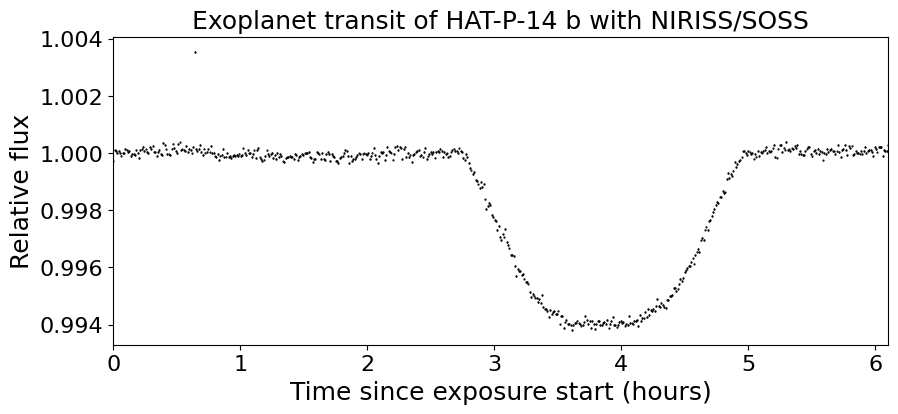

In [4]:
tstart = t[0]
time_since_start = (t-tstart)*24

plt.figure(figsize=(10,4))

plt.errorbar(time_since_start, f, ferr, fmt = '.', 
                         ms = 1, mfc = 'black', mec = 'black', 
                         elinewidth = 1, ecolor = 'black')

plt.title('Exoplanet transit of HAT-P-14 b with NIRISS/SOSS', fontsize = 18)
plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(np.min(time_since_start), np.max(time_since_start))
plt.show()

All right. This time-series shows a nice transit event from about hour 2.75 since exposure start, all the way until about hour 5. Aside from the transit event, however, there is an evident oscillation in the data, which is evident if we do a zoom to the first three hours of data:

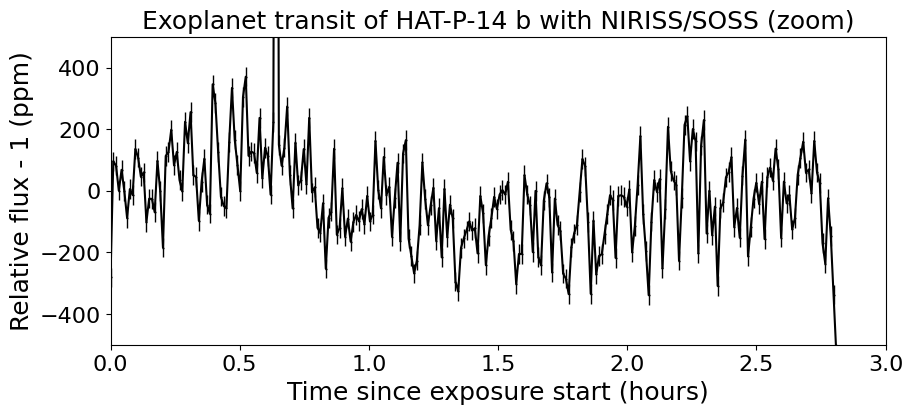

In [5]:
tstart = t[0]
time_since_start = (t-tstart)*24

plt.figure(figsize=(10,4))

plt.plot(time_since_start, (f-1)*1e6, color = 'black')
plt.errorbar(time_since_start, (f-1)*1e6, ferr*1e6, fmt = '.', 
                         ms = 1, mfc = 'black', mec = 'black', 
                         elinewidth = 1, ecolor = 'black')

plt.title('Exoplanet transit of HAT-P-14 b with NIRISS/SOSS (zoom)', fontsize = 18)
plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux - 1 (ppm)', fontsize = 18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(np.min(time_since_start), 3)
plt.ylim(-500, 500)

plt.show()

The light curve has at least two oscillation patterns. One is a long-term one, on which the light curve seems to rise at about hour 0.5 after start, then go down until about hour 1, and then oscillate up again at about hour 3. The other is a short-frequency oscillation, with a period of about ~5 minutes. The amplitude of those oscillations is small --- around 200 ppm.

Big question is: are those oscillations really happening on HAT-P-14 (the star)? Or is this an instrumental effect? Let's now explore the guidestar data to find this out.

### 1.2 Exploring the guidestar data of PID 1541

Let's use `spelunker` to load the guidestar data for this Program ID/observation/visit. To get these values, one can explore the Program Information webpage for the program [here](https://www.stsci.edu/jwst/science-execution/program-information?id=1541) and click on the ["Visit Status Information" page](https://www.stsci.edu/jwst/science-execution/program-information?id=1541) that will present this data to a user. In our case, this dataset corresponds to PID 1541, observation number 1 and visit 1: 

In [6]:
spk = spelunker.load(pid=1541, obs_num='1', visit='1', save=True)

Current working directory for spelunker: /Users/nespinoza/github/JWST-FGS-Spelunker/notebooks/spelunker_outputs

Connecting with astroquery...


Let's check the time-series of the guidestar data:

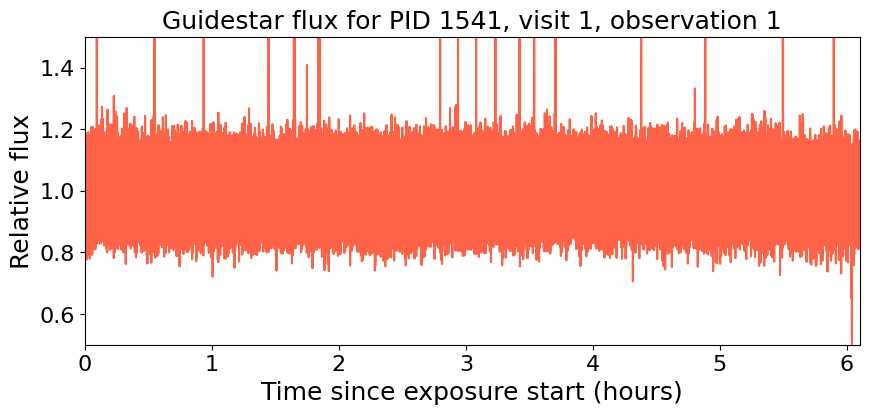

In [8]:
plt.figure(figsize=(10,4))

fg_time_since_start = (spk.fg_time + 2400000.5 - tstart) * 24

plt.plot(fg_time_since_start, spk.fg_flux / np.nanmedian( spk.fg_flux ) , color = 'tomato')

plt.title('Guidestar flux for PID 1541, visit 1, observation 1', fontsize = 18)
plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)

plt.ylim(0.5,1.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(np.min(time_since_start), np.max(time_since_start))
plt.show()

The raw photometry from the guidestar varies by a lot more than our target star due to random noise in the very high cadence JWST FGS data. Let's bin the FGS time-series to the same cadence as the science time-series, which will allow us to see more structure in the data. To this end, let's write a function that does this: 

In [9]:
def bin_fgs_to_science(tscience, tfgs, ffgs):
    """
    This function bins an FGS time-series defined by the times `tfgs` and fluxes `ffgs`, to times `tscience`. 
    The function assumes that (1) `tscience` are times obtained at pseudo-regular intervals (i.e., that times 
    on `tscience` next to each other are similar), and that (2) `tscience` is ordered in chronological order.
    """

    nscience = len(tscience)
    binned_fgs = np.zeros( nscience )
    binned_fgs_err = np.zeros( nscience )
    for i in range( nscience ):

        if i == 0:

            dt = tscience[1] - tscience[0] 

        elif i == nscience - 1:

            dt = tscience[-1] - tscience[-2]

        else:

            dt1 = tscience[i] - tscience[i-1]
            dt2 = tscience[i+1] - tscience[i]
            dt = ( dt1 + dt2 ) * 0.5
            
        idx = np.where( np.abs(tscience[i] - tfgs) < 0.5*dt )[0]
        binned_fgs[i] = np.mean( ffgs[idx] )
        binned_fgs_err[i] = np.sqrt( np.var( ffgs[idx] ) ) / np.sqrt( len(idx) )

    return binned_fgs, binned_fgs_err

In [11]:
fbin, fbinerr = bin_fgs_to_science(time_since_start, fg_time_since_start, spk.fg_flux / np.nanmedian( spk.fg_flux ))

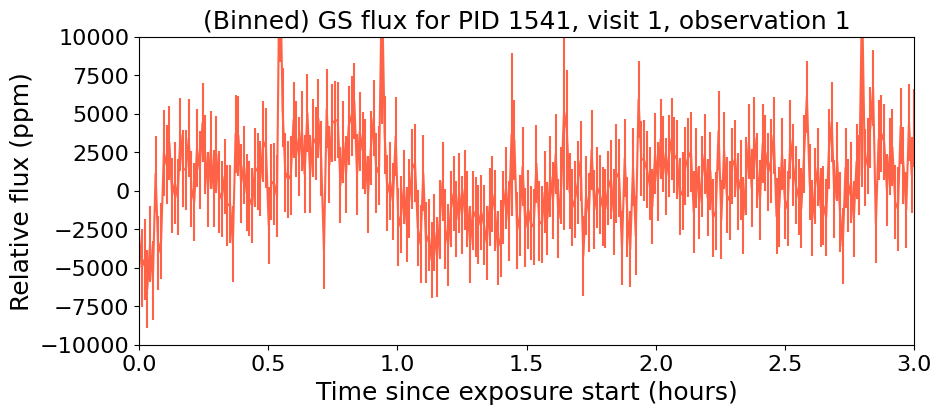

In [12]:
plt.figure(figsize=(10,4))

plt.errorbar(time_since_start, (fbin-1)*1e6, fbinerr*1e6, color = 'tomato')

plt.title('(Binned) GS flux for PID 1541, visit 1, observation 1', fontsize = 18)
plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux (ppm)', fontsize = 18)

plt.ylim(1.0-0.05,1+0.05)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(-10000, 10000)
plt.xlim(np.min(time_since_start), 3)
plt.show()

This actually resembles the science time-series quite nicely, although at a different amplitude. Let's plot both on the same figure:

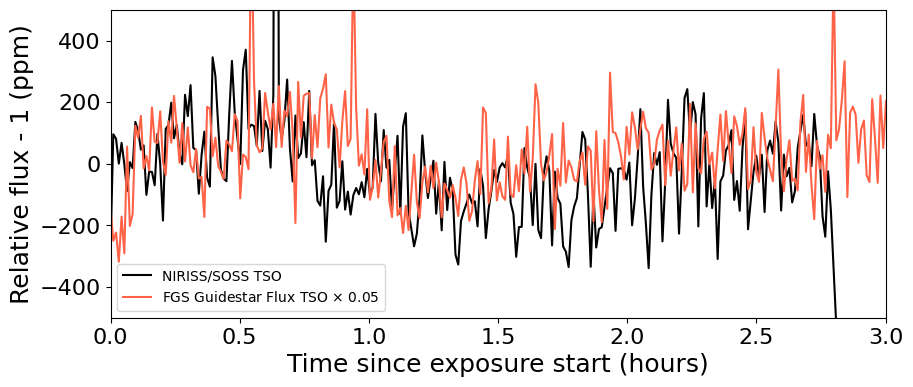

In [13]:
tstart = t[0]
time_since_start = (t-tstart)*24

plt.figure(figsize=(10,4))

plt.plot(time_since_start, (f-1)*1e6, color = 'black', label = 'NIRISS/SOSS TSO')

plt.plot(time_since_start, (fbin-1)*1e6*0.05, color = 'tomato', label = r'FGS Guidestar Flux TSO $\times$ 0.05')

plt.legend()
plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux - 1 (ppm)', fontsize = 18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(np.min(time_since_start), 3)
plt.ylim(-500, 500)

plt.show()

Remarkable! The amplitude might need some tweaking, but it seems this can, indeed, help track some lightcurve variations. Let's look next at other features that could be correlated with instrumental systematics. 

### 1.3 More, more! Correlating PSF Guidestar properties to JWST TSOs

`spelunker` can also fit Gaussians to each of the 2D FG frames, and extract more precise parameters than the simple "crude" photometry described above. This takes a while (a few minutes), so we need to be a bit patient. Note there's a series of messages that appear below --- these come from `ray`, a multi-processing library `spelunker` uses in the background. None of the errors are important for our particular application.

In [14]:
spk.gauss2d_fit(ncpus=4)

2024-04-16 16:16:39,230	INFO worker.py:1621 -- Started a local Ray instance.
(ray_curve_fit pid=57955) /Users/nespinoza/opt/anaconda3/envs/newen/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
(ray_curve_fit pid=57955)   warnings.warn('Covariance of the parameters could not be estimated',
(raylet) [2024-04-16 16:16:48,271 E 57952 8609050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-16_16-16-34_773037_57708 is over 95% full, available space: 15959072768; capacity: 994662584320. Object creation will fail if spilling is required.
(raylet) [2024-04-16 16:16:58,366 E 57952 8609050] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-16_16-16-34_773037_57708 is over 95% full, available space: 15960264704; capacity: 994662584320. Object creation will fail if spilling is required.
(raylet) [2024-04-16 16:17:08,454 E 57952 8609050] (raylet) file_system_monitor.cc:111: /tmp/ray/session

amplitude,x_mean,y_mean,x_stddev,y_stddev,theta,offset
float64,float64,float64,float64,float64,float64,float64
96.13580818091697,2.9489472302249555,2.8459489641612317,0.6615126270671262,0.5982857173004258,0.5084229861100592,1.0716251998893254
93.22999728230792,2.945971179314676,2.8321791067722404,0.6774501510971196,0.610760669468479,0.3324114335819944,0.7014456008012028
94.83739704115126,2.94180146636494,2.82125715177069,0.6799938081616088,0.6012986779279296,0.40859458291440265,0.6536850854022012
94.12867663693092,2.959077309637642,2.851779332482687,0.6862760348911927,0.5881373871809559,0.43462908400767114,1.193779403425883
95.09568324476194,2.9776655111309482,2.843257410088901,0.6745053368568955,0.5948537560303414,0.4436336278798898,0.6849093750054519
96.09149159005842,2.936042771168488,2.8397027851196017,0.6561865491418671,0.5921877323474933,0.31271186839202075,1.0385142236743439
93.06601773302175,2.9582766713032673,2.840213774481902,0.6859924101227998,0.5978256132575925,0.46184526017998145,0.8806879415652762
95.15724811906438,2.9347155045134685,2.8328760483424262,0.6745937018526853,0.5993837247150425,0.4211280503380404,0.658471868047228
96.06142234317561,2.9440039388675543,2.8479086849909647,0.6594548212895818,0.593266419414752,0.48804906052479596,1.1317705816434056


In [15]:
results = {}

for key in list(spk.gaussfit_results.keys()):

    results[key], _ = bin_fgs_to_science(time_since_start, 
                                         fg_time_since_start, 
                                         spk.gaussfit_results[key].value)

In [16]:
print(results.keys())

dict_keys(['amplitude', 'x_mean', 'y_mean', 'x_stddev', 'y_stddev', 'theta', 'offset'])


Let's plot all of those parameters for the entire duration of the TSO:

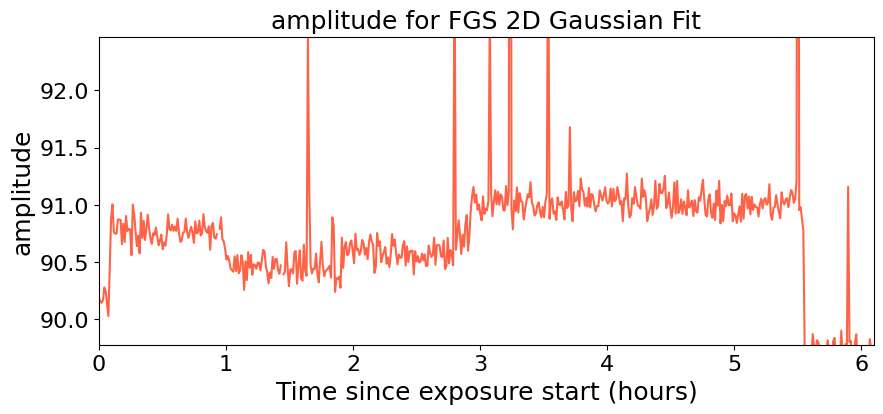

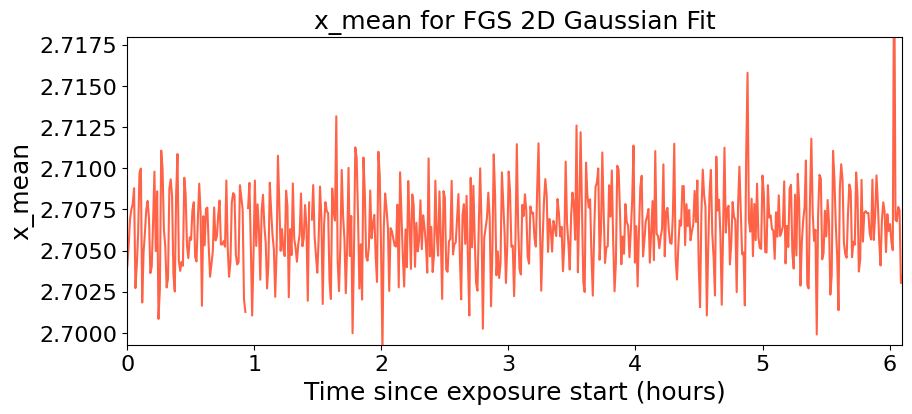

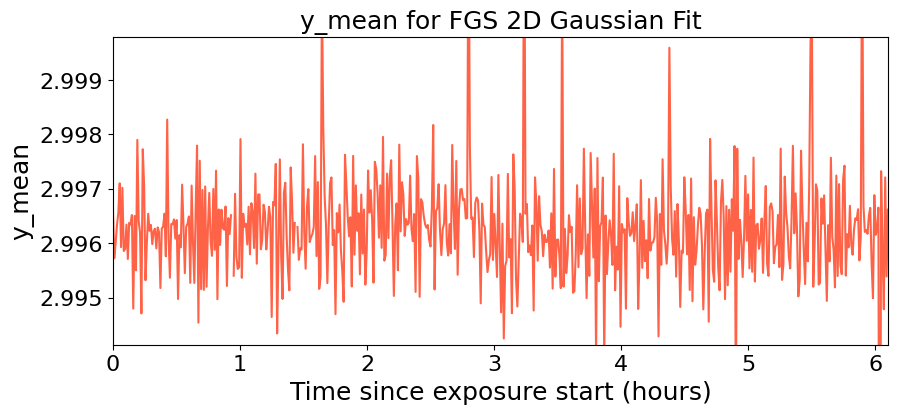

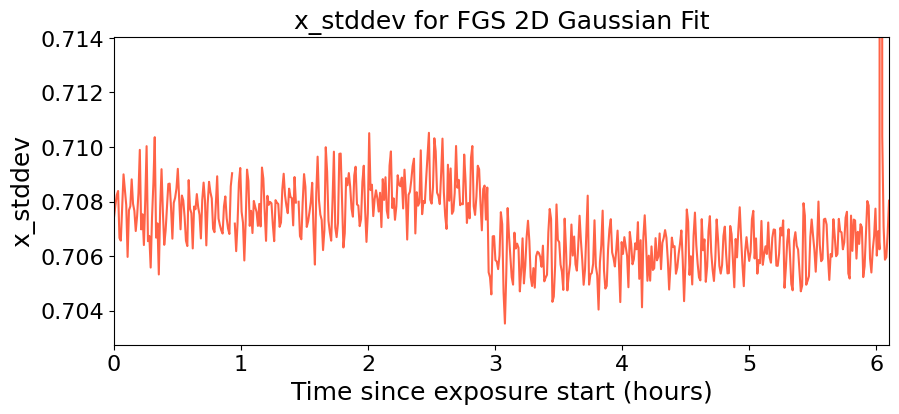

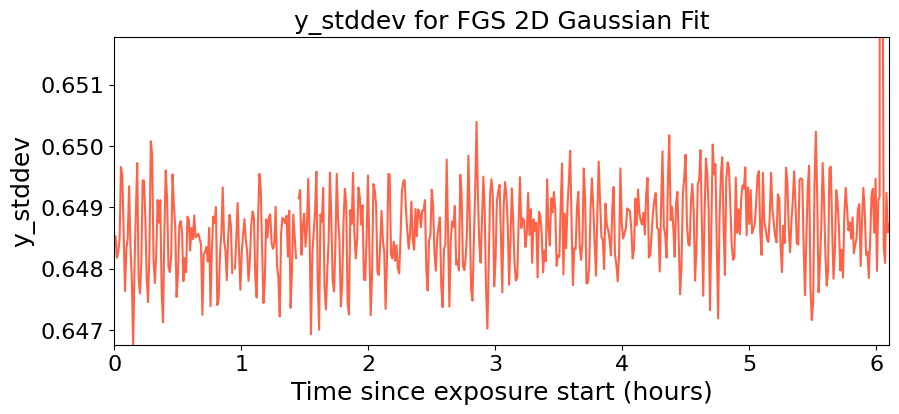

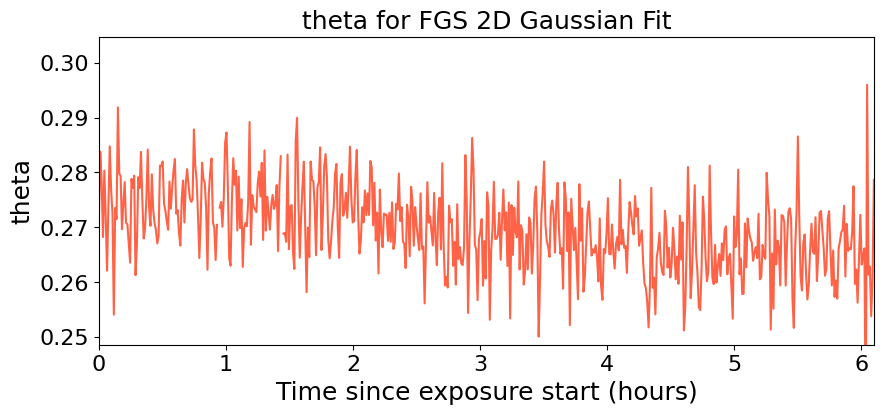

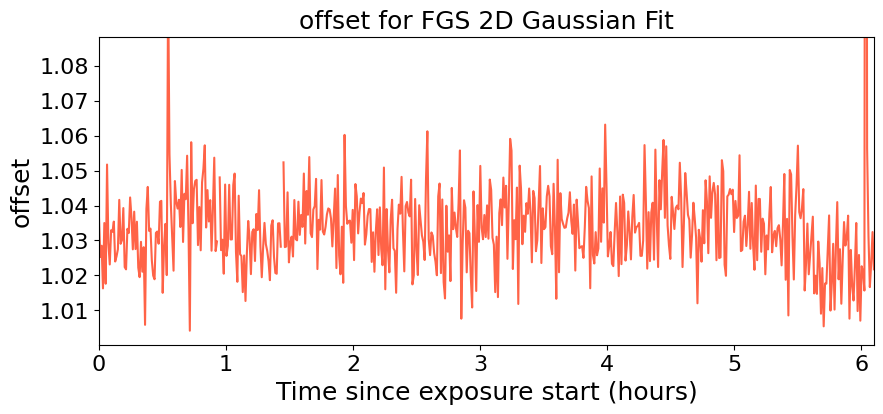

In [17]:
for key in list(results.keys()):

    plt.figure(figsize=(10,4))

    median = np.nanmedian(results[key])
    std = np.nanmedian(np.abs(results[key] - median)) * 1.4826
    plt.plot(time_since_start, results[key], color = 'tomato')
    
    plt.title(key+' for FGS 2D Gaussian Fit', fontsize = 18)
    plt.xlabel('Time since exposure start (hours)', fontsize = 18)
    plt.ylabel(key, fontsize = 18)
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.xlim(np.min(time_since_start), np.max(time_since_start))
    plt.ylim(median-3*std,median+5*std)

plt.show()

Neat! Many things to unpack. 

First, note how the position in X (`x_mean`) and the standard deviation in this direction (`x_stddev`), together with the standard deviation on the y-direction (`y_stddev`) and the rotation angle of the gaussian (`theta`) all oscillate in short frequency, in concert with the science TSO. Let's compare those time-series on top of the science TSO for the first three hours. To do this, let's create a helper function that standarizes our regressors:

In [18]:
def standarize(x):

    median = np.nanmedian(x)
    std = np.nanmedian(np.abs(x - median)) * 1.4826    

    return ( x - median ) / std

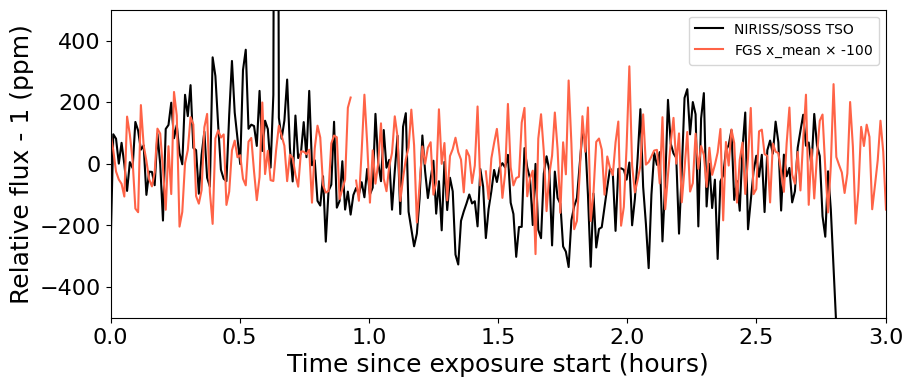

In [19]:
variable = 'x_mean'

plt.figure(figsize=(10,4))

plt.plot(time_since_start, (f-1)*1e6, color = 'black', label = 'NIRISS/SOSS TSO')

plt.plot(time_since_start, standarize(results[variable])*100*(-1), 
         color = 'tomato', label = r'FGS '+variable+r' $\times$ -100')

plt.legend()
plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux - 1 (ppm)', fontsize = 18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(np.min(time_since_start), 3)
plt.ylim(-500, 500)

plt.show()

Very nice correlation between variables! Also, note how the x-standard deviation detects what appears to be a small "tilt event" --- [un-commanded changes of the primary mirror segments](https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/jwst-time-series-observations-noise-sources#JWSTTimeSeriesObservationsNoiseSources-%22Tilt%22events), believed to happen due to release of stored stresses in the mirror ([Lajoie et al., 2023](https://www.stsci.edu/files/live/sites/www/files/home/jwst/documentation/technical-documents/_documents/JWST-STScI-008497.pdf)) --- and which manifest as abrupt PSF position and shape changes:

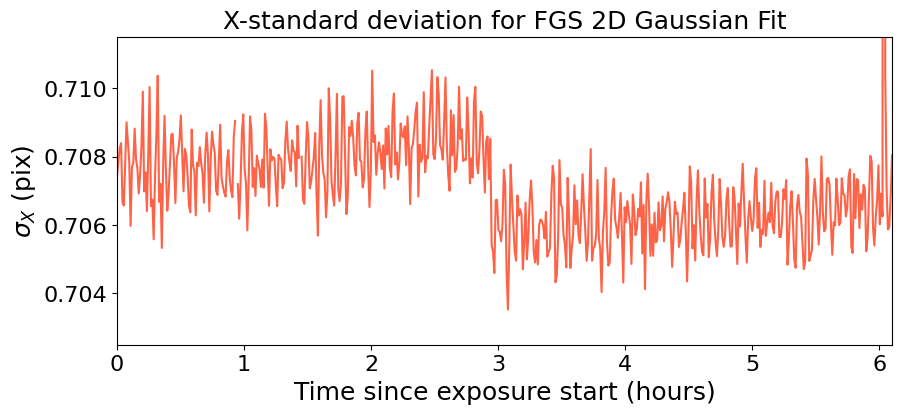

In [20]:
plt.figure(figsize=(10,4))

plt.plot(time_since_start, results['x_stddev'], color = 'tomato')
    
plt.title('X-standard deviation for FGS 2D Gaussian Fit', fontsize = 18)
plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('$\sigma_X$ (pix)', fontsize = 18)
    
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0.7025,0.7115)
plt.xlim(np.min(time_since_start), np.max(time_since_start))

plt.show()

Seeing this from the actual TSO is quite difficult, because the tilt event happened _just_ during ingress:

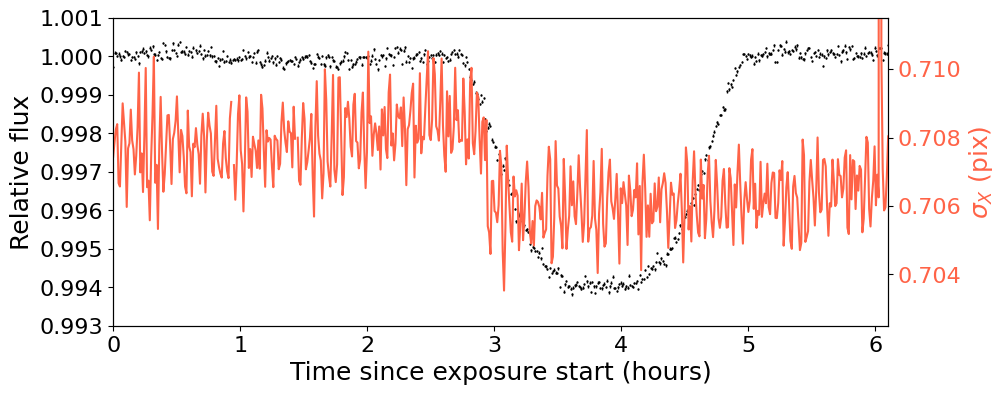

In [21]:
plt.figure(figsize=(10,4))

plt.errorbar(time_since_start, f, ferr, fmt = '.', 
                         ms = 1, mfc = 'black', mec = 'black', 
                         elinewidth = 1, ecolor = 'black')

plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)


plt.xlim(np.min(time_since_start), np.max(time_since_start))
plt.ylim(0.993, 1.001)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.twinx()
variable = 'x_stddev'
plt.plot(time_since_start, results[variable], 
         color = 'tomato', label = r'FGS '+variable)

plt.ylim(0.7025,0.7115)

plt.ylabel('$\sigma_X$ (pix)', fontsize = 18, color = 'tomato')

plt.yticks(fontsize=16, color = 'tomato')

plt.show()

To showcase further the beauty of `spelunker` as a TSO event detector, let's analyze one more dataset on which the tilt event is obvious: the ERS observations of WASP-39 b with NIRSpec/G395H.

# 2. The case of WASP-39 b NIRSpec/G395H observations

Let's repeat the analysis for the transit WASP-39 b with NIRSpec/G395H. Let's study the NRS1 lightcurve presented in [Alderson et al. (2023)](https://www.nature.com/articles/s41586-022-05591-3). This lightcurve, as the one for HAT-P-14 b introduced above, was also generated using the `transitspectroscopy` pipeline --- we have uploaded this to this Github repository as well [here](https://raw.githubusercontent.com/GalagaBits/JWST-FGS-Spelunker/main/notebooks/data/w39_lightcurve.dat). We extract the time, flux and error on the flux:

In [22]:
t, f, ferr = np.loadtxt('data/w39_lightcurve.dat', unpack = True, usecols = (0,1,2))

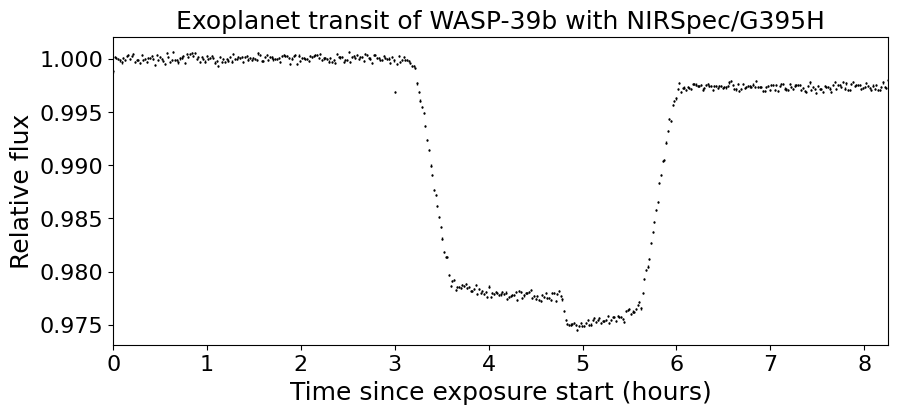

In [23]:
tstart = t[0]
time_since_start = (t-tstart)*24

plt.figure(figsize=(10,4))

plt.errorbar(time_since_start, f, ferr, fmt = '.', 
                         ms = 1, mfc = 'black', mec = 'black', 
                         elinewidth = 1, ecolor = 'black')

plt.title('Exoplanet transit of WASP-39b with NIRSpec/G395H', fontsize = 18)
plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(np.min(time_since_start), np.max(time_since_start))

plt.show()

Note that break in the transit light curve? That's a tilt event. One that `spelunker` can also detect! Let's run the `spelunker` magic for this program, which is [PID 1366 (PI: Batalha, co-PI: Bean, Stevenson)](https://www.stsci.edu/jwst/science-execution/program-information?id=1366). This, in particular, is observation number 3, visit 1:

In [24]:
spk = spelunker.load(pid=1366, obs_num='3', visit='1', save=True)

Current working directory for spelunker: /Users/nespinoza/github/JWST-FGS-Spelunker/notebooks/spelunker_outputs

Connecting with astroquery...


Let's explore the guidestar (binned) photometry:

In [25]:
fg_time_since_start = (spk.fg_time + 2400000.5 - tstart) * 24
fbin, fbinerr = bin_fgs_to_science(time_since_start, fg_time_since_start, spk.fg_flux / np.nanmedian( spk.fg_flux ))

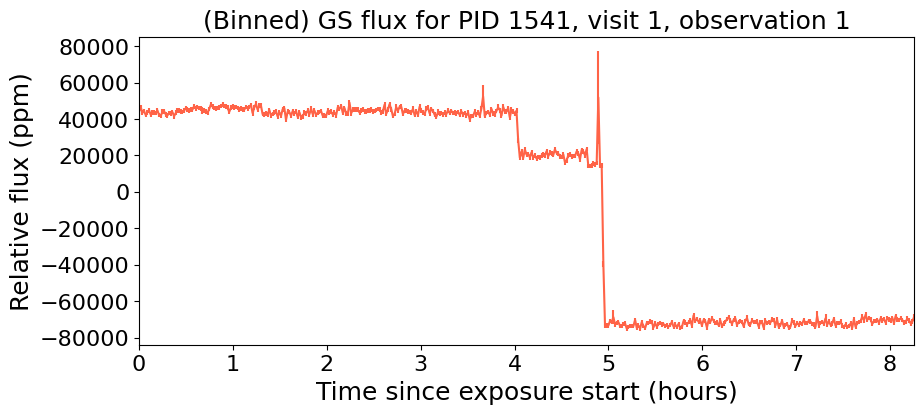

In [26]:
plt.figure(figsize=(10,4))

plt.errorbar(time_since_start, (fbin-1)*1e6, fbinerr*1e6, color = 'tomato')

plt.title('(Binned) GS flux for PID 1541, visit 1, observation 1', fontsize = 18)
plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux (ppm)', fontsize = 18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(np.min(time_since_start), np.max(time_since_start))

plt.show()

Oh my. It's not only one, but perhaps...two, three tilt events?:

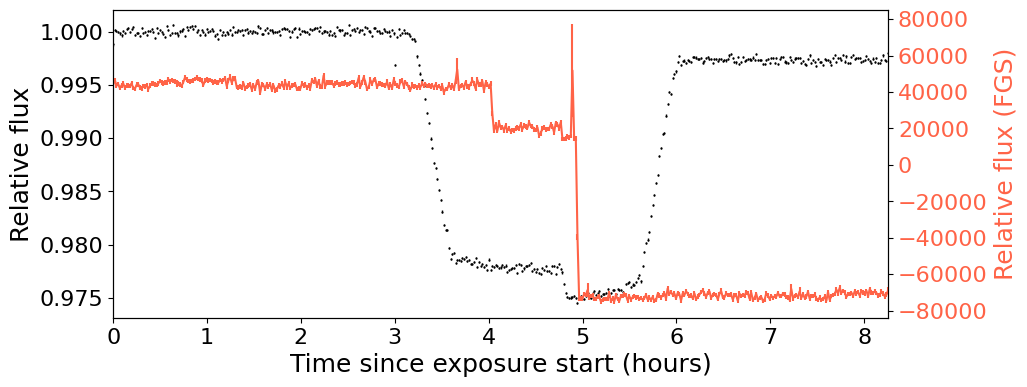

In [27]:
tstart = t[0]
time_since_start = (t-tstart)*24

plt.figure(figsize=(10,4))

plt.errorbar(time_since_start, f, ferr, fmt = '.', 
                         ms = 1, mfc = 'black', mec = 'black', 
                         elinewidth = 1, ecolor = 'black')

plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(np.min(time_since_start), np.max(time_since_start))

plt.twinx()

plt.errorbar(time_since_start, (fbin-1)*1e6, fbinerr*1e6, color = 'tomato')

plt.ylabel('Relative flux (FGS)', fontsize = 18, color = 'tomato')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16, color = 'tomato')

plt.show()

Very interesting. Let's explore the gaussian fits to the data:

In [28]:
spk.gauss2d_fit(ncpus=4)

2024-04-16 16:26:41,219	INFO worker.py:1621 -- Started a local Ray instance.
(raylet) [2024-04-16 16:26:51,256 E 58355 8617929] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-16_16-26-39_189576_57708 is over 95% full, available space: 12387164160; capacity: 994662584320. Object creation will fail if spilling is required.
(raylet) [2024-04-16 16:27:01,345 E 58355 8617929] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-16_16-26-39_189576_57708 is over 95% full, available space: 12386103296; capacity: 994662584320. Object creation will fail if spilling is required.
(raylet) [2024-04-16 16:27:11,438 E 58355 8617929] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-16_16-26-39_189576_57708 is over 95% full, available space: 12385538048; capacity: 994662584320. Object creation will fail if spilling is required.
(raylet) [2024-04-16 16:27:21,530 E 58355 8617929] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-04-16_16-26-39_189576_57708 is

amplitude,x_mean,y_mean,x_stddev,y_stddev,theta,offset
float64,float64,float64,float64,float64,float64,float64
101.2130834715611,3.3337142065501806,3.1211539297881297,0.678794985526882,0.6455960073417324,-5.700622557705897,1.2600173683376603
101.2130834715611,3.3337142065501806,3.1211539297881297,0.678794985526882,0.6455960073417324,-5.700622557705897,1.2600173683376603
103.05905733146207,3.333717026231874,3.1426918922609515,0.6992886159347997,0.6215193135956538,3.7093620371234532,0.4315052638558577
103.05905733146207,3.333717026231874,3.1426918922609515,0.6992886159347997,0.6215193135956538,3.7093620371234532,0.4315052638558577
107.62423515399446,3.3329848174350096,3.1209278591494467,0.670653457453187,0.6134283967686914,0.5304734402909416,1.034035794662567
107.62423515399446,3.3329848174350096,3.1209278591494467,0.670653457453187,0.6134283967686914,0.5304734402909416,1.034035794662567
105.13549643350163,3.3404461485036183,3.146541679405182,0.6194982061925448,0.674314197583598,2.0496654166262434,0.34170455477240214
105.13549643350163,3.3404461485036183,3.146541679405182,0.6194982061925448,0.674314197583598,2.0496654166262434,0.34170455477240214
105.81118078745634,3.3294497330551542,3.1567471050837046,0.6192618835433593,0.6871994010025763,8.319006284847053,1.0360085349313437


Let's bin this to the science time-stamps:

In [31]:
results = {}

for key in list(spk.gaussfit_results.keys()):

    results[key], _ = bin_fgs_to_science(time_since_start, 
                                         fg_time_since_start, 
                                         spk.gaussfit_results[key].value)

Let's go right away to the X standard deviation:

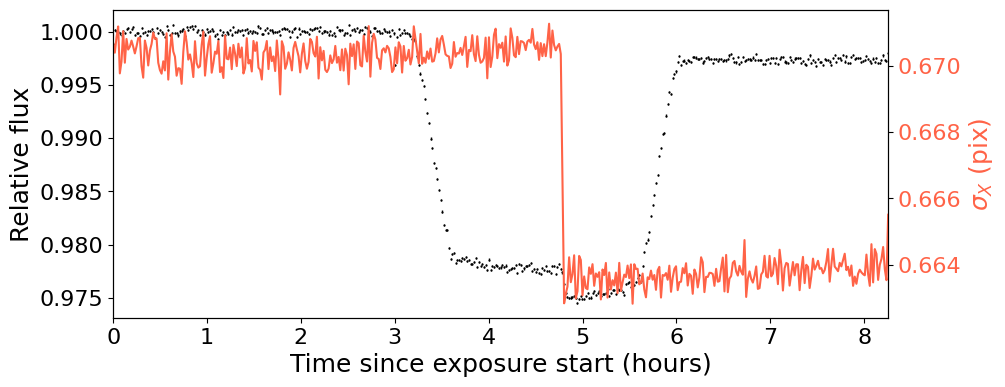

In [32]:
plt.figure(figsize=(10,4))

plt.errorbar(time_since_start, f, ferr, fmt = '.', 
                         ms = 1, mfc = 'black', mec = 'black', 
                         elinewidth = 1, ecolor = 'black')

plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)


plt.xlim(np.min(time_since_start), np.max(time_since_start))

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.twinx()
variable = 'x_stddev'
plt.plot(time_since_start, results[variable], 
         color = 'tomato', label = r'FGS '+variable)

plt.ylabel('$\sigma_X$ (pix)', fontsize = 18, color = 'tomato')

plt.yticks(fontsize=16, color = 'tomato')

plt.show()

Very interesting! The "tilt" event is beautifully detected by the guidestar data. Best of all, we can see the event at any resolution we want thanks to it, because the FGS data has much higher tempoeral resolution that the TSO data itself. Let's write a function that can bin the data at any temporal resolution so we can see this in action:

In [33]:
def bin_data(x,y,n_bin):
    
    x_bins = []
    y_bins = []
    y_err_bins = []
    
    for i in range(0,len(x),n_bin):
        
        x_bins.append(np.median(x[i:i+n_bin-1]))
        y_bins.append(np.median(y[i:i+n_bin-1]))
        y_err_bins.append(np.sqrt(np.var(y[i:i+n_bin-1]))/np.sqrt(len(y[i:i+n_bin-1])))
        
    return np.array(x_bins),np.array(y_bins),np.array(y_err_bins)

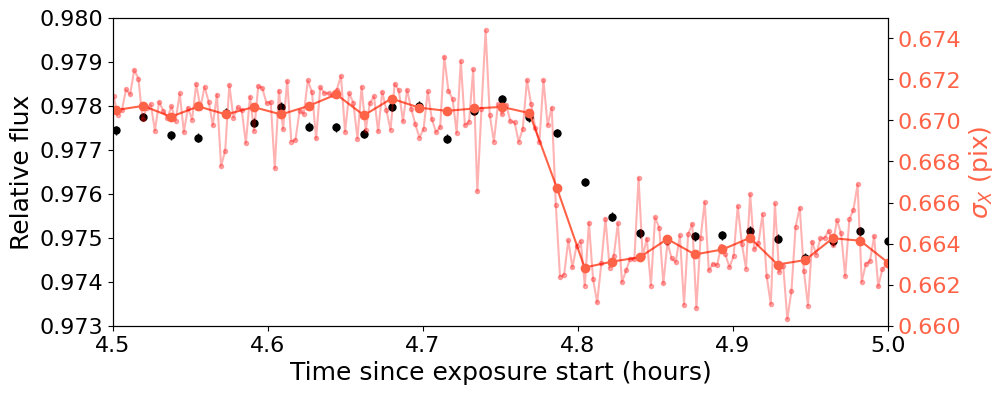

In [34]:
plt.figure(figsize=(10,4))

plt.errorbar(time_since_start, f, ferr, fmt = 'o', 
                         ms = 5, mfc = 'black', mec = 'black', 
                         elinewidth = 1, ecolor = 'black')

plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)


plt.xlim(4.5,5.0)
plt.ylim(0.973, 0.980)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.twinx()

variable = 'x_stddev'
plt.plot(time_since_start, results[variable], 
         color = 'tomato', label = r'FGS '+variable)

tbin, ybin, _ = bin_data((spk.fg_time + 2400000.5 - tstart) * 24, spk.gaussfit_results[variable].value, n_bin = 300)
plt.plot(tbin, ybin, '.-',
         color = 'red', alpha = 0.3)

plt.plot(time_since_start, results[variable], 
         'o', color = 'tomato')

plt.xlim(4.5,5.0)
plt.ylim(0.66,0.675)

plt.ylabel('$\sigma_X$ (pix)', fontsize = 18, color = 'tomato')

plt.yticks(fontsize=16, color = 'tomato')

plt.show()

Interestingly, in this case, the Y-standard deviation samples the event even better, when considering the amplitude of the "jump" in this time series to the overall scatter of the time-series for the Y-standard deviation itself, $\sigma_Y$:

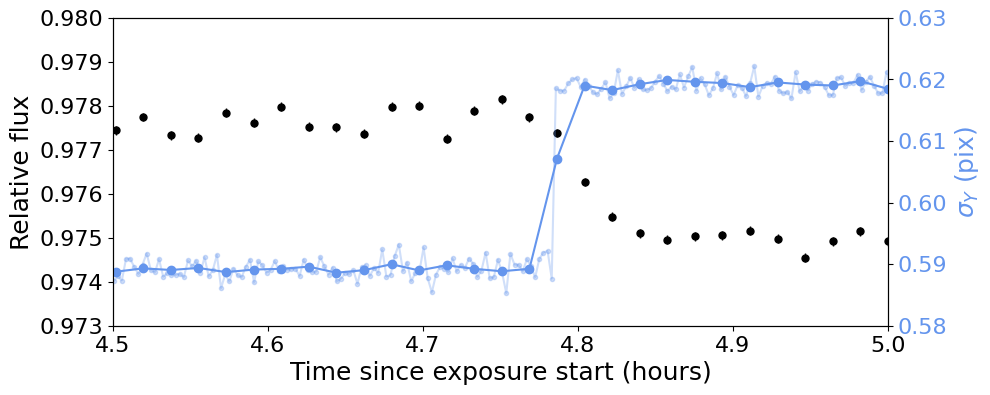

In [35]:
plt.figure(figsize=(10,4))

plt.errorbar(time_since_start, f, ferr, fmt = 'o', 
                         ms = 5, mfc = 'black', mec = 'black', 
                         elinewidth = 1, ecolor = 'black')

plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)


plt.xlim(4.5,5.0)
plt.ylim(0.973, 0.980)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.twinx()

variable = 'y_stddev'
plt.plot(time_since_start, results[variable], 
         color = 'cornflowerblue', label = r'FGS '+variable)

tbin, ybin, _ = bin_data((spk.fg_time + 2400000.5 - tstart) * 24, spk.gaussfit_results[variable].value, n_bin = 300)
plt.plot(tbin, ybin, '.-',
         color = 'cornflowerblue', alpha = 0.3)

plt.plot(time_since_start, results[variable], 
         'o', color = 'cornflowerblue')

plt.xlim(4.5,5.0)
plt.ylim(0.58,0.63)

plt.ylabel('$\sigma_Y$ (pix)', fontsize = 18, color = 'cornflowerblue')

plt.yticks(fontsize=16, color = 'cornflowerblue')

plt.show()

It is very interesting how while the change of the PSF in the guidestar is almost instantaneous, the PSF change in the TSO is slightly smoother. This smooth behavior is actually quite nicely tracked by the mean positions:

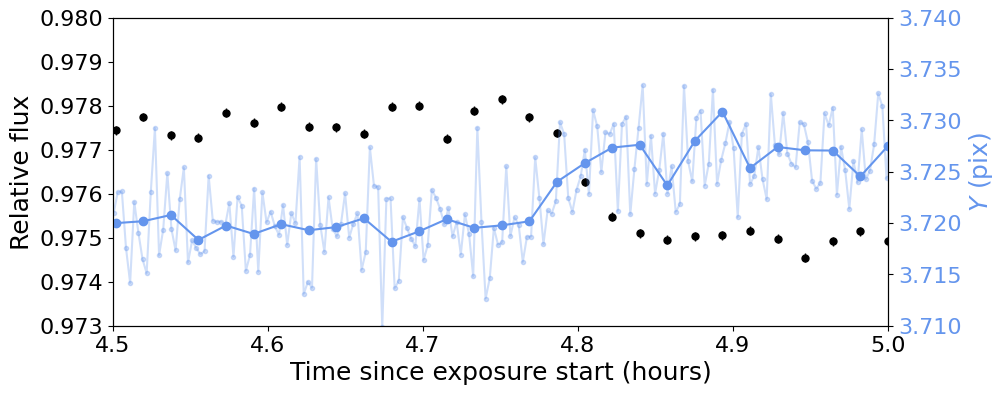

In [36]:
plt.figure(figsize=(10,4))

plt.errorbar(time_since_start, f, ferr, fmt = 'o', 
                         ms = 5, mfc = 'black', mec = 'black', 
                         elinewidth = 1, ecolor = 'black')

plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)


plt.xlim(4.5,5.0)
plt.ylim(0.973, 0.980)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.twinx()

variable = 'y_mean'
plt.plot(time_since_start, results[variable], 
         color = 'cornflowerblue', label = r'FGS '+variable)

tbin, ybin, _ = bin_data((spk.fg_time + 2400000.5 - tstart) * 24, spk.gaussfit_results[variable].value, n_bin = 300)
plt.plot(tbin, ybin, '.-',
         color = 'cornflowerblue', alpha = 0.3)

plt.plot(time_since_start, results[variable], 
         'o', color = 'cornflowerblue')

plt.xlim(4.5,5.0)
plt.ylim(3.71,3.74)

plt.ylabel('$Y$ (pix)', fontsize = 18, color = 'cornflowerblue')

plt.yticks(fontsize=16, color = 'cornflowerblue')

plt.show()

It is this availability of derived products from the FGS frames what makes this data so rich and powerful when compared against science data. In particular, the different ways in which different FGS parameters might correlate with the science data might be useful to decorrelate the science time-series itself, which might help correcting for events such as the ones showcased above.